# Setup & get data

In [87]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=30)
mpl.rc('font', size=30)
mpl.rc('xtick', labelsize=22)
mpl.rc('ytick', labelsize=22)
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn import metrics
import math

%run -i ../scripts/pandas_startup.py

In [14]:
daily_incidents=pd.read_csv("../data/daily_incidents_clean.csv", index_col=None)

In [26]:
daily_incidents = daily_incidents[["ds", "y"]]

# Split data into training and validation (i.e., "test") sets

Make validation set as latest / most recent days.

In [27]:
validation_window = 60  # days
train_df, validation_df = train_test_split(daily_incidents, test_size=validation_window, shuffle=False)

In [28]:
assert(((len(train_df) == (len(daily_incidents)-60)) & (len(validation_df) == validation_window)))

In [29]:
train_df.head(2)

,ds,y
0,2018/01/01,214
1,2018/01/02,172


In [30]:
validation_df.head(2)

,ds,y
1492,2022/02/01,126
1493,2022/02/02,146


# Plot historical data

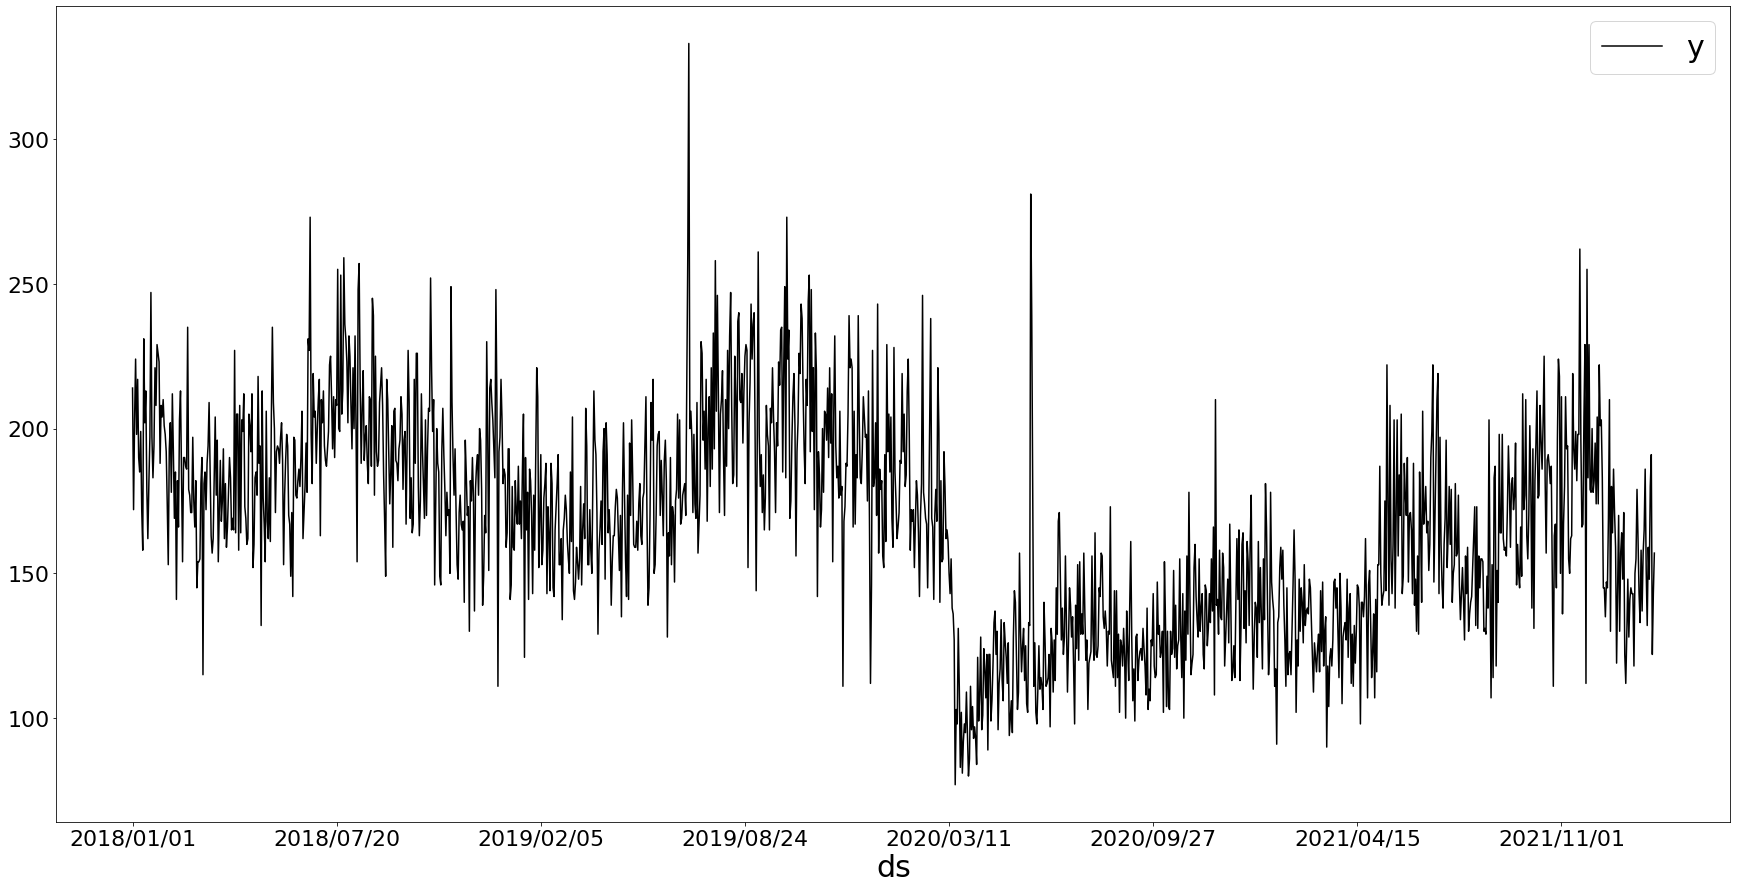

In [88]:
fig, ax = plt.subplots(figsize=(30, 15))

train_df.plot('ds', 'y', 
                     color="black", 
                     ax=ax)

plt.show()

# Forecast

In [32]:
prophet_config_dict = {
    "weekly_seasonality": True,
    "daily_seasonality": True,
}


In [53]:
prophet_forecaster_object = Prophet(**prophet_config_dict)
prophet_forecaster_object.add_country_holidays("US")
prophet_forecaster_object

If you get `Prophet' object has no attribute 'stan_backend'`, do `pip install pystan==2.19.1.1`


In [54]:
prophet_forecaster_object.fit(train_df)
train_future_df = prophet_forecaster_object.make_future_dataframe(periods=365, freq="d")
print()
print()
print("Empty rows of future dates, to fill with predictions:")
print()
print(train_future_df.sort_values)
train_forecast_df = prophet_forecaster_object.predict(train_future_df)
print()
print()
print("Predictions for future dates (yhat is the predicted value):")
print()
print(train_forecast_df[['ds', 'yhat']].tail(5))

Initial log joint probability = -11.4192


Empty rows of future dates, to fill with predictions:

<bound method DataFrame.sort_values of              ds
0    2018-01-01
1    2018-01-02
2    2018-01-03
3    2018-01-04
4    2018-01-05
...         ...
1852 2023-01-27
1853 2023-01-28
1854 2023-01-29
1855 2023-01-30
1856 2023-01-31

[1857 rows x 1 columns]>
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3208.44    0.00253801       148.596           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3215.39   0.000173889       176.656   1.324e-06       0.001      271  LS failed, Hessian reset 
     199       3216.28    0.00369201       306.012      0.5339      0.5339      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3220.71   0.000389777        59.674           1           1      429 

## Evaluate fit

By comparing the actual values from the validation set (the latest validation_window days), with the predicted values on those dates from the training set.

In [72]:
earliest_validation_date = min(validation_df["ds"])
latest_validation_date = max(validation_df["ds"])
train_forecast_validation_dates = train_forecast_df[train_forecast_df['ds'].between(earliest_validation_date, latest_validation_date)]

MSE/RMSE is a mean, so overweights hi errors, so more sensitive to outliers than MAE.



In [80]:
print('Mean Squared Error:', mse(validation_df["y"], train_forecast_validation_dates["yhat"]))
print('Root Mean Squared Error:', np.sqrt(mse(validation_df["y"], train_forecast_validation_dates["yhat"])))
print('mean_absolute_error:', metrics.mean_absolute_error(validation_df["y"], train_forecast_validation_dates["yhat"]))


Mean Squared Error: 793.8603196763589
Root Mean Squared Error: 28.1755269635966
mean_absolute_error: 21.535891020384444


RMSE means typical prediction error of 28 incidents.

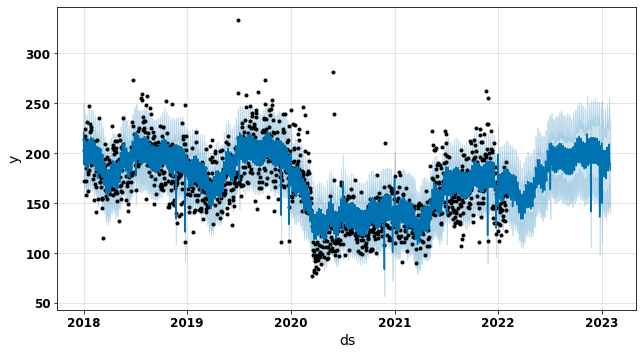

In [197]:
fig1 = prophet_forecaster_object.plot(train_forecast_df)

In [198]:
df_prophet.dtypes

ds    object
y      int64
dtype: object

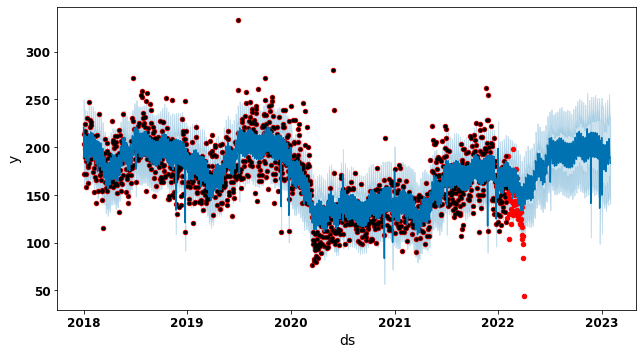

In [204]:
import warnings
warnings.filterwarnings('ignore')
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
prophet_forecaster_object.plot(train_forecast_df)
df_prophet.plot.scatter(x="ds", y="y", color="red", ax=plt.gca())
plt.show()

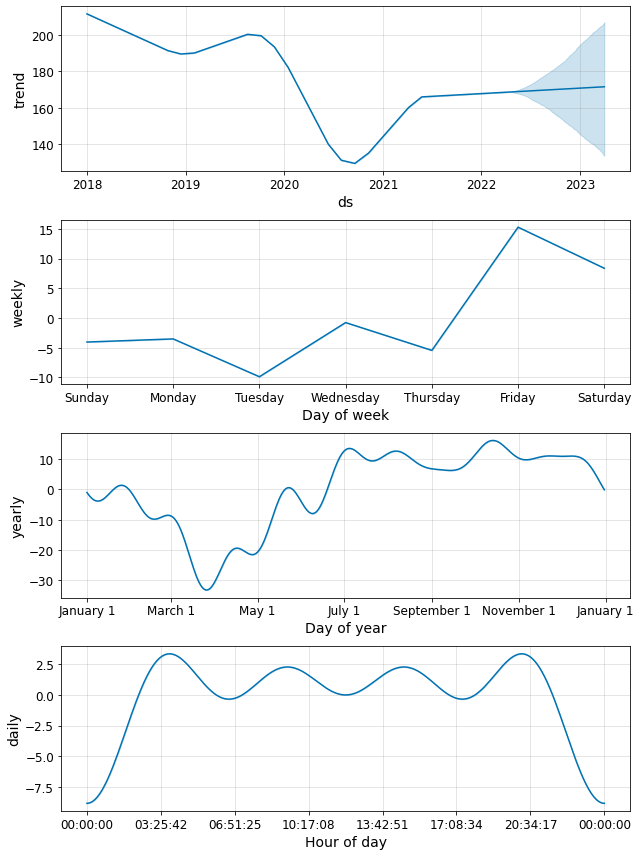

In [105]:
fig2 = prophet_forecaster_object.plot_components(forecast)
